Total observations: 41435
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41435 entries, 0 to 41434
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Filename   41435 non-null  object 
 1   ClassID    41435 non-null  int64  
 2   ClassName  41435 non-null  object 
 3   Width      41435 non-null  float64
 4   Height     41435 non-null  float64
 5   Area       41435 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.9+ MB
            ClassID         Width        Height          Area
count  41435.000000  41435.000000  41435.000000  41435.000000
mean      10.348425      0.242740      0.254388      0.073400
std        6.426400      0.244421      0.167947      0.100285
min        0.000000      0.009642      0.001266      0.000012
25%        4.000000      0.089333      0.128285      0.012692
50%       10.000000      0.148899      0.212521      0.035520
75%       18.000000      0.266119      0.325230   

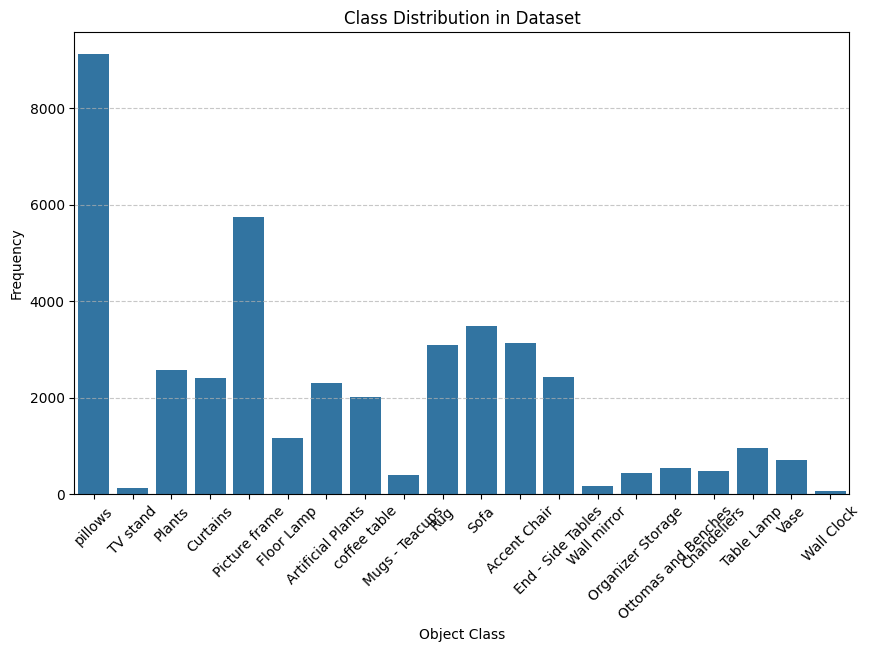

Top 5 Smallest Objects:
                                                Filename  ClassID  \
31760  garrison-hullinger-interior-design-inc-img7511...        0   
31780  garrison-hullinger-interior-design-inc-img7511...        0   
31800  garrison-hullinger-interior-design-inc-img7511...        0   
4616      28_jpg.rf.2ee843083709baf22aa6e2646669b97e.txt        9   
4666      28_jpg.rf.c409726d9877011181b19a5a6a885983.txt        9   

           ClassName     Width    Height      Area  
31760   Accent Chair  0.009730  0.001266  0.000012  
31780   Accent Chair  0.009730  0.001266  0.000012  
31800   Accent Chair  0.009642  0.001481  0.000014  
4616   Picture frame  0.017370  0.025215  0.000438  
4666   Picture frame  0.017370  0.025215  0.000438  


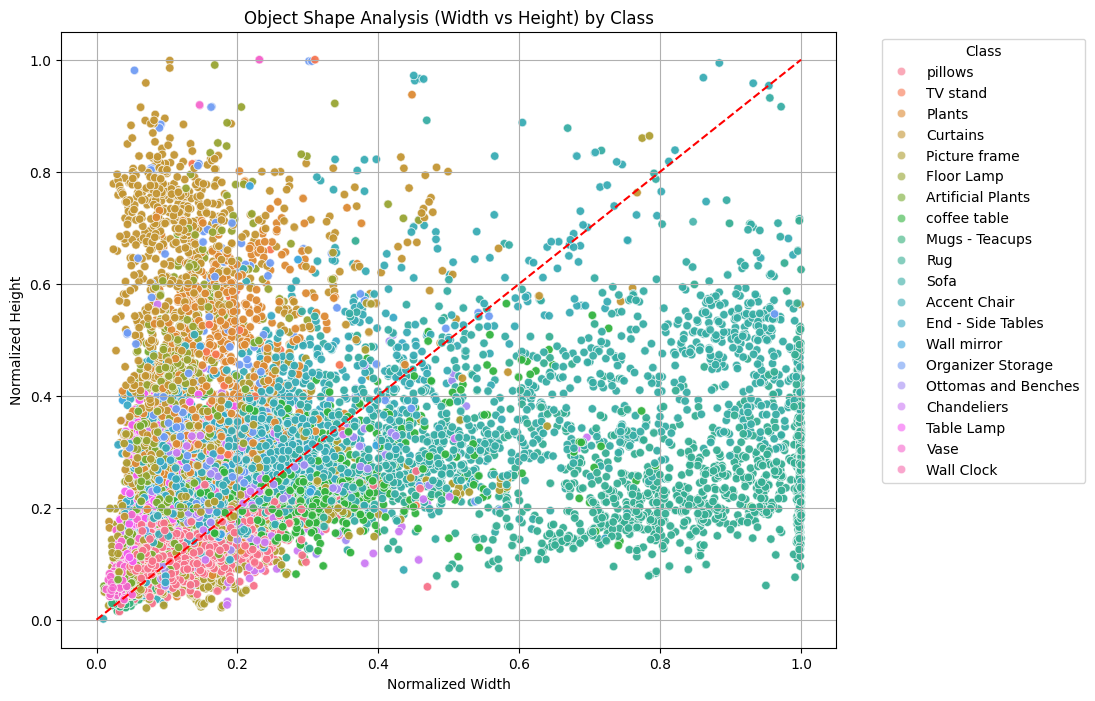

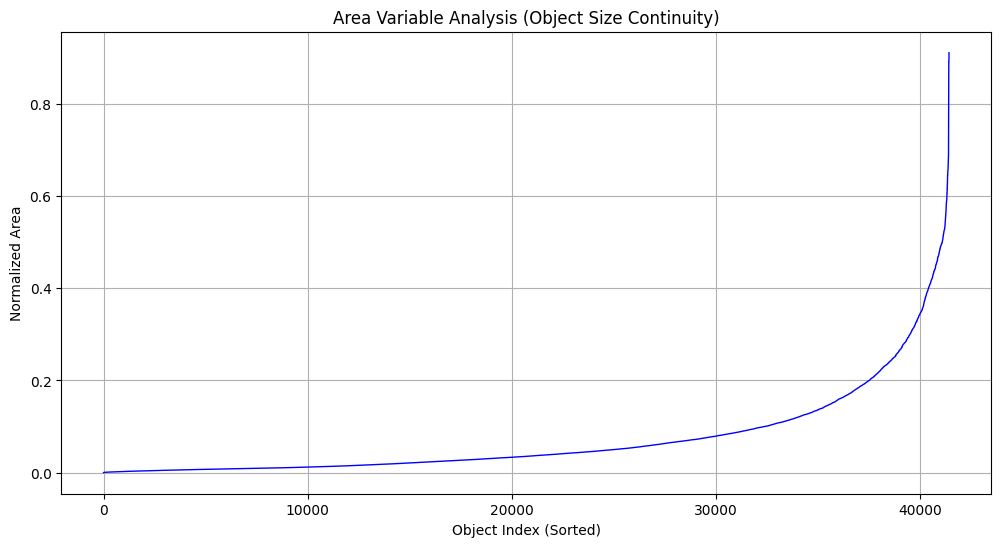

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import glob
import yaml
from roboflow import Roboflow

# Configure environment and retrieve dataset (local check or download)
API_KEY = os.getenv("ROBOFLOW_API_KEY", "YOUR_API_KEY_HERE") 
WORKSPACE = "living-room"
PROJECT = "living-room-hn7cw"
VERSION = 9

def get_dataset_path():
    cwd = os.getcwd()
    base_dir = os.path.abspath(os.path.join(cwd, ".."))
    data_dir = os.path.join(base_dir, "data", "base_dataset")
    
    if os.path.exists(data_dir) and len(os.listdir(data_dir)) > 0:
        subfolders = [f.path for f in os.scandir(data_dir) if f.is_dir()]
        return subfolders[0] if subfolders else data_dir
        
    print(f"Downloading dataset to: {os.path.relpath(data_dir, base_dir)}")
    os.makedirs(data_dir, exist_ok=True)
    os.chdir(data_dir)
    
    try:
        rf = Roboflow(api_key=API_KEY)
        project = rf.workspace(WORKSPACE).project(PROJECT)
        version = project.version(VERSION)
        dataset = version.download("yolov8")
        location = dataset.location
    except Exception as e:
        print(f"Error initializing Roboflow: {e}")
        location = data_dir
    finally:
        os.chdir(cwd)
    return location

dataset_path = get_dataset_path()

# Parse YOLO txt label files to construct a Pandas DataFrame
def build_dataframe(root_path):
    yaml_path = os.path.join(root_path, "data.yaml")
    if not os.path.exists(yaml_path):
        return pd.DataFrame()

    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    class_names = config['names']
    
    path_labels = os.path.join(root_path, "train", "labels", "*.txt")
    txt_files = glob.glob(path_labels)
    
    data = []
    for file_path in txt_files:
        file_name = os.path.basename(file_path)
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls_id = int(parts[0])
                    w = float(parts[3])
                    h = float(parts[4])
                    data.append({
                        'Filename': file_name,
                        'ClassID': cls_id,
                        'ClassName': class_names[cls_id],
                        'Width': w,
                        'Height': h,
                        'Area': w * h
                    })
    return pd.DataFrame(data)

df = build_dataframe(dataset_path)

# Display general dataset statistics and structure
print(f'Total observations: {df.shape[0]}')
df.info()
print(df.describe())

# Visualize Class Distribution (Univariate Analysis)
plt.figure(figsize=(10, 6))
sns.countplot(x=df['ClassName'])
plt.title('Class Distribution in Dataset')
plt.xlabel('Object Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Sort data by Area to analyze object sizes
df_sorted = df.sort_values(by=['Area'])
print("Top 5 Smallest Objects:")
print(df_sorted.head(5))

# Analyze Object Shapes: Width vs Height by Class (Bivariate Analysis)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='Width', y='Height', hue='ClassName', alpha=0.6)
plt.title('Object Shape Analysis (Width vs Height) by Class')
plt.xlabel('Normalized Width')
plt.ylabel('Normalized Height')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Square (1:1 Ratio)') 
plt.show()

# Visualize Area continuity (Single Variable Analysis)
df_area_sorted = df_sorted.sort_values(by=['Area'])
variable_analysis = df_area_sorted.loc[:, ['Area']]
x_axis = range(len(df_area_sorted.index))

plt.figure(figsize=(12, 6))
plt.plot(x_axis, variable_analysis, color='blue', linestyle='-', linewidth=1)
plt.title('Area Variable Analysis (Object Size Continuity)')
plt.xlabel('Object Index (Sorted)')
plt.ylabel('Normalized Area')
plt.grid(True)
plt.show()